# Base Deep Neural Network Model

Base DNN Model used as a framework for all other models. Described in details in chapter 4.2.

Input: 6 key indicators passed separately

Output: optimal max-shape portfolio with normal restrictions for the next period

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense
from keras.regularizers import L2
from keras.optimizers import Adam
from keras.utils import plot_model

import os
os.chdir(os.path.expanduser('../'))

from helper_functions import show_loss, calculate_returns_for_model, calculate_metrics

## Data Pre-processing

In [3]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider
from PortfolioOptimizer import PortfolioOptimizer

In [4]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
days_to_recalculate = data_provider.get_days_to_recalculate()

Preparing features

In [5]:
x = []
for date in days_to_recalculate:
    indicators_arr = []
    for indicator in data_provider.key_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

x = np.array(x)

In [6]:
x.shape

(288, 6, 162)

In [14]:
pd.DataFrame(columns=data_provider.selected_countries, data=x[0,:,:27])

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
0,0.658050,-0.682986,-0.061875,0.739923,0.062347,-0.510769,-0.330082,0.626994,0.629817,0.319262,...,-0.682986,1.555838,0.158337,1.451378,2.758535,-0.798739,0.415252,-0.211506,-0.025173,-0.070345
1,0.658050,-0.682986,-0.061875,0.739923,0.062347,-0.510769,-0.330082,0.626994,0.629817,0.319262,...,-0.682986,1.555838,0.158337,1.451378,2.758535,-0.798739,0.415252,-0.211506,-0.025173,-0.070345
2,0.658050,-0.682986,-0.061875,0.739923,0.062347,-0.510769,-0.330082,0.626994,0.629817,0.319262,...,-0.682986,1.555838,0.158337,1.451378,2.758535,-0.798739,0.415252,-0.211506,-0.025173,-0.070345
3,0.677812,-0.581350,0.305146,0.931903,0.324908,-0.344198,-0.149395,0.406782,0.785095,0.398312,...,0.234565,1.471141,0.223272,1.281984,3.080384,-0.804385,0.708868,0.163984,0.104696,0.195039
4,0.677812,-0.581350,0.305146,0.931903,0.324908,-0.344198,-0.149395,0.406782,0.785095,0.398312,...,0.234565,1.471141,0.223272,1.281984,3.080384,-0.804385,0.708868,0.163984,0.104696,0.195039
5,0.677812,-0.581350,0.305146,0.931903,0.324908,-0.344198,-0.149395,0.406782,0.785095,0.398312,...,0.234565,1.471141,0.223272,1.281984,3.080384,-0.804385,0.708868,0.163984,0.104696,0.195039


Preparing targets

In [7]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    optimizer = PortfolioOptimizer()
    w, constraints = optimizer.get_normal_constraints(acwi_weights_year)
    optimal_portfolio = optimizer.get_optimal_portfolio(
        data_period, w, constraints)
    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

(288, 27)

In [18]:
pd.DataFrame(columns=data_provider.selected_countries, data=y[:1])

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
0,0.249,0.173,0.054,0.045,0.074,0.016,0.071,0.007,0.008,0.03,...,0.002,0.001,0.03,0.03,0.002,0.03,0.03,0.003,0.03,0.03


## Train/validation/test split

In [8]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
print('Dates for train', dates_for_training)
x_train = x[:val_split]
print('x train shape', x_train.shape)
y_train = y[:val_split]
print('y train shape', y_train.shape)

Dates for train DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2015-12-03', '2016-01-06', '2016-02-03', '2016-03-03',
               '2016-04-06', '2016-05-05', '2016-06-03', '2016-07-06',
               '2016-08-03', '2016-09-07'],
              dtype='datetime64[ns]', name='Days to rebalance', length=201, freq=None)
x train shape (201, 6, 162)
y train shape (201, 27)


In [9]:
# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
print('Dates for validation', dates_for_validation)
x_val = x[val_split:test_split]
print('x val shape', x_val.shape)
y_val = y[val_split:test_split]
print('y val shape', y_val.shape)

Dates for validation DatetimeIndex(['2016-10-05', '2016-11-03', '2016-12-06', '2017-01-11',
               '2017-02-03', '2017-03-03', '2017-04-06', '2017-05-05',
               '2017-06-06', '2017-07-06', '2017-08-03', '2017-09-06',
               '2017-10-06', '2017-11-03', '2017-12-05', '2018-01-04',
               '2018-02-06', '2018-03-06', '2018-04-06', '2018-05-04',
               '2018-06-05', '2018-07-06', '2018-08-03', '2018-09-05',
               '2018-10-04', '2018-11-06', '2018-12-06', '2019-01-10',
               '2019-02-08'],
              dtype='datetime64[ns]', name='Days to rebalance', freq=None)
x val shape (29, 6, 162)
y val shape (29, 27)


In [10]:
# Test
dates_for_test = days_to_recalculate[test_split:]
print('Dates for test', dates_for_test)
x_test = x[test_split:]
print('x test shape', x_test.shape)
y_test = y[test_split:]
print('y test shape', y_test.shape)

Dates for test DatetimeIndex(['2019-03-05', '2019-04-04', '2019-05-07', '2019-06-05',
               '2019-07-05', '2019-08-06', '2019-09-04', '2019-10-04',
               '2019-11-05', '2019-12-04', '2020-01-09', '2020-02-05',
               '2020-03-04', '2020-04-03', '2020-05-06', '2020-06-03',
               '2020-07-07', '2020-08-05', '2020-09-03', '2020-10-07',
               '2020-11-04', '2020-12-03', '2021-01-06', '2021-02-03',
               '2021-03-03', '2021-04-08', '2021-05-05', '2021-06-03',
               '2021-07-07', '2021-08-04', '2021-09-03', '2021-10-06',
               '2021-11-03', '2021-12-03', '2022-01-11', '2022-02-08',
               '2022-03-04', '2022-04-06', '2022-05-06', '2022-06-07',
               '2022-07-06', '2022-08-03', '2022-09-07', '2022-10-06',
               '2022-11-03', '2022-12-06', '2023-01-09', '2023-02-03',
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023

## Model definition and training

In [21]:
base_dnn_model = Sequential((
    Input(shape=x_train.shape[1:]),
    Flatten(name='Flatten'),
    Dense(16, activation='relu', name='Dense', 
          kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax', name='Output')
))

base_dnn_model.compile(optimizer=Adam(), loss='mse')

base_dnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 972)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 16)             │        15,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,027 (62.61 KB)

 Trainable params: 16,027 (62.61 KB)

 Non-trainable params: 0 (0.00 B)

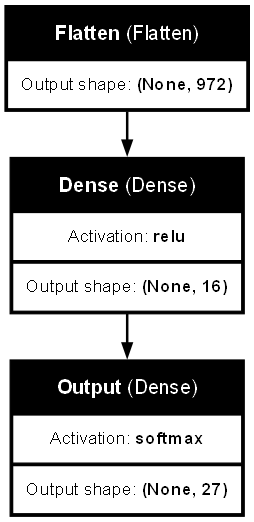

In [22]:
plot_model(base_dnn_model, show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=90)

In [23]:
hist = base_dnn_model.fit(x_train, y_train, epochs=100,
                          validation_data=(x_val, y_val))

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.9733 - val_loss: 2.3962
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2359 - val_loss: 1.7717
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6454 - val_loss: 1.2834
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1868 - val_loss: 0.9118
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8395 - val_loss: 0.6361
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5828 - val_loss: 0.4359
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3979 - val_loss: 0.2937
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2668 - val_loss: 0.1946
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1757 - val_loss: 0.1268
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1140 - val_loss: 0.0815
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0727 - val_loss: 0.0518
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0460 - val_loss: 0.0328


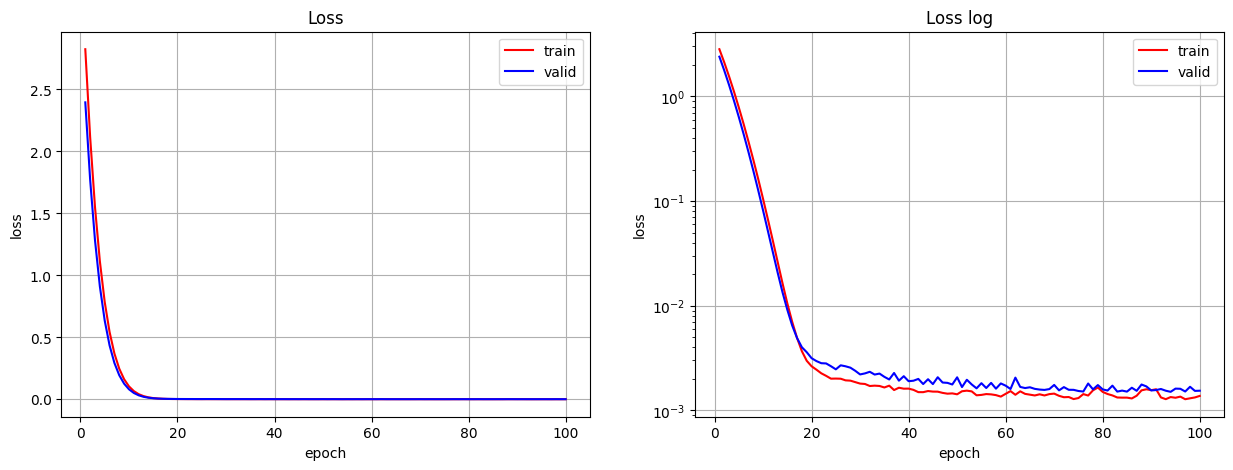

In [24]:
show_loss(hist.history)

In [25]:
train_error = base_dnn_model.evaluate(x_train, y_train)
print('Train error:', train_error)

val_error = base_dnn_model.evaluate(x_val, y_val)
print('Val error:', val_error)

test_error = base_dnn_model.evaluate(x_test, y_test)
print('Test error:', test_error)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0012      
Train error: 0.0012925229966640472
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Val error: 0.0015421457355841994
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0019  
Test error: 0.0017894336488097906


## Backtesting

In [26]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [27]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [28]:
(total_returns, cummulative_total_returns) = calculate_returns_for_model(
    base_dnn_model, x_test, dates_for_test, df_returns_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


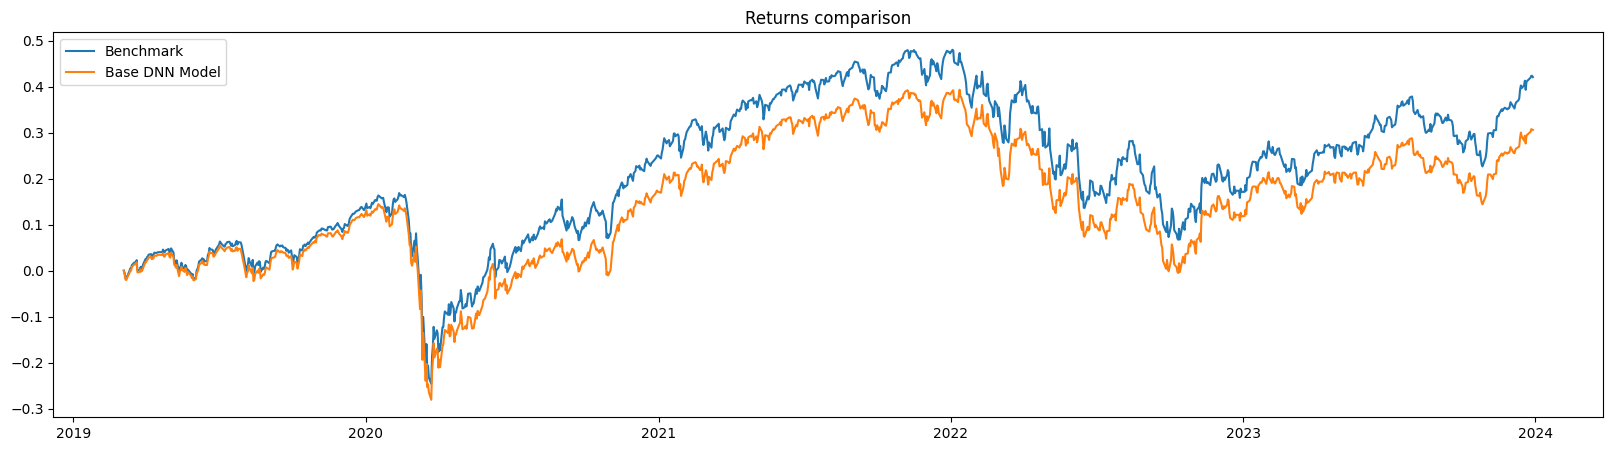

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cummulative_total_returns, label='Base DNN Model')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [30]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                    'Annual Volatility',
                                    'Sharpe Ratio',
                                    'Sortino Ratio',
                                    'Max Drawdown',
                                    'Max Time Under Water',
                                    'Calmar Ratio',
                                    'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns, df_results, 'Base DNN Model', benchmark_returns)
df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Base DNN Model,0.057612,0.201135,0.286435,0.329345,-0.371605,493.0,0.155036,-0.610356
